In [1]:
import pandas as pd

# Постановка задачи

Возьмем небольшой датасет __Sentiment140__ [вот отсюда](http://help.sentiment140.com/for-students/).

В архиве два файла, первый - демонстрационный - содержит около 500 сообщений Твиттера, размеченных по тональности на классы _"нейтральных"_, _"положительных"_ и _"отрицательных"_. Второй файл уже посерьезнее, и содержит 1 600 000 твитов (~240Mb).

Играться будем с первым, пытаясь предсказать тональность той небольшой группы, что на руках.

_P.s._: у этих же ребят [вот здесь](http://help.sentiment140.com/other-resources) есть перечень открытых ресурсов с датасетами по sentiment analysis.

In [2]:
df = pd.read_csv('data/Sentiment140/testdata.manual.2009.06.14.csv', header=None)
df.columns = ['polarity', 'id', 'date', 'query', 'user', 'text']

In [3]:
df.drop(['id', 'date', 'query', 'user'], axis=1, inplace=True)

In [4]:
df.shape

(498, 2)

In [5]:
df.head()

,polarity,text
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...


# Шаги предобработки и подготовки текста

## Токенизация

Токенизация - процесс разделения текста на слова. И задача вовсе не тривиальная, как может показаться на первый взгляд. "Нью-Йорк" - это один токен или два? А "красно-синий" - два или один? "Воруй-убивай" - два? "Тем не менее" - один или три? 

Как только начинаешь задумываться об автоматизации и построении токенизаторов, всплывает множество любопытных нюансов вроде приведенных выше примеров.

In [7]:
from nltk import word_tokenize, wordpunct_tokenize, sent_tokenize

In [9]:
s = df.text[1]
s

'Reading my kindle2...  Love it... Lee childs is good read.'

In [11]:
import re

In [12]:
tokens = [x.lower() for x in word_tokenize(s) if re.match("[a-zA-Z\d]+", x) is not None]
tokens

['reading',
 'my',
 'kindle2',
 'love',
 'it',
 'lee',
 'childs',
 'is',
 'good',
 'read']

## Стоп-слова

Следующий важный шаг: выбрасывания из текста таких слов, которые встречаются равномерно везде, и никакой полезной информации не несут.

In [13]:
from nltk.corpus import stopwords

In [14]:
[print(x, end='\t\b') for x in stopwords.words('english')];

i	me	my	myself	we	our	ours	ourselves	you	your	yours	yourself	yourselves	he	him	his	himself	she	her	hers	herself	it	its	itself	they	them	their	theirs	themselves	what	which	who	whom	this	that	these	those	am	is	are	was	were	be	been	being	have	has	had	having	do	does	did	doing	a	an	the	and	but	if	or	because	as	until	while	of	at	by	for	with	about	against	between	into	through	during	before	after	above	below	to	from	up	down	in	out	on	off	over	under	again	further	then	once	here	there	when	where	why	how	all	any	both	each	few	more	most	other	some	such	no	nor	not	only	own	same	so	than	too	very	s	t	can	will	just	don	should	now	d	ll	m	o	re	ve	y	ain	aren	couldn	didn	doesn	hadn	hasn	haven	isn	ma	mightn	mustn	needn	shan	shouldn	wasn	weren	won	wouldn	

In [15]:
[print(x, end='\t\b') for x in stopwords.words('russian')];

и	в	во	не	что	он	на	я	с	со	как	а	то	все	она	так	его	но	да	ты	к	у	же	вы	за	бы	по	только	ее	мне	было	вот	от	меня	еще	нет	о	из	ему	теперь	когда	даже	ну	вдруг	ли	если	уже	или	ни	быть	был	него	до	вас	нибудь	опять	уж	вам	ведь	там	потом	себя	ничего	ей	может	они	тут	где	есть	надо	ней	для	мы	тебя	их	чем	была	сам	чтоб	без	будто	чего	раз	тоже	себе	под	будет	ж	тогда	кто	этот	того	потому	этого	какой	совсем	ним	здесь	этом	один	почти	мой	тем	чтобы	нее	сейчас	были	куда	зачем	всех	никогда	можно	при	наконец	два	об	другой	хоть	после	над	больше	тот	через	эти	нас	про	всего	них	какая	много	разве	три	эту	моя	впрочем	хорошо	свою	этой	перед	иногда	лучше	чуть	том	нельзя	такой	им	более	всегда	конечно	всю	между	

In [16]:
throwed = [x for x in tokens if x in stopwords.words('english')]
throwed

['my', 'it', 'is']

In [17]:
filtered_tokens = [x for x in tokens if x not in stopwords.words('english')]
filtered_tokens

['reading', 'kindle2', 'love', 'lee', 'childs', 'good', 'read']

## Лемматизация или стемминг

В сложных естественных языках (таких как русский язык) одно и то же слово может принимать разные формы (падежи), и в словарь частотного анализа могут попадать все словоформы, отличающиеся предлогами и/или окончаниями. Из-за этого может сильно увеличиваться размер словаря и соответственно размер набора данных для обучения, что может вызывать падение производительности системы и ухудшать обобщающие способности классификатора (переобучение).

Первый - это __лемматизация__. Суть лемматизации заключается в том, что все слова в тексте приводятся к нормальной форме (единственное число  именительного падежа). Лемматизация требует словарей языков, на которых написан текст, она выполняет поиск для всех слов текста их нормальной формы по словарям, и это может существенно снижать производительность.

Второй метод - это __стемминг__. Суть стемминга - выделение основы слов путём отбрасывания приставок и окончаний. Этот способ нормализации текста работает гораздо быстрее чем лематизация. Он менее качественный но для частотного анализа его вполне достаточно.

### Лемматизация

__PROS:__

1. Нормализация текста не использует стемминг, поэтому она лишена недостатков потери релевантности из-за особенностей русского словоизменения.

__CONS:__

1. Внешние зависимости.
2. Скорость работы.
3. Новые неопределенности на уровне морфологии языка:

```
Мы роем яму ---<lemmatizer>---> мы (рыть? рой?) яма
```

In [18]:
from nltk import WordNetLemmatizer

In [19]:
wnl = WordNetLemmatizer()

In [21]:
lemmatized = [wnl.lemmatize(x, pos='v') for x in filtered_tokens]

for a,b in zip(filtered_tokens, lemmatized):
    print(a.rjust(10), '->', b.ljust(10), '' if a == b else '<- processed!')

   reading -> read       <- processed!
   kindle2 -> kindle2    
      love -> love       
       lee -> lee        
    childs -> childs     
      good -> good       
      read -> read       


In [22]:
lemmatized = [wnl.lemmatize(x) for x in filtered_tokens] # default is Noun

for a,b in zip(filtered_tokens, lemmatized):
    print(a.rjust(10), '->', b.ljust(10), '' if a == b else '<- processed!')

   reading -> reading    
   kindle2 -> kindle2    
      love -> love       
       lee -> lee        
    childs -> child      <- processed!
      good -> good       
      read -> read       


Следовательно, нам нужна предварительное разеделение по частям речи. Выполним его:

In [25]:
from nltk import pos_tag

In [26]:
pos_tag(filtered_tokens)

[('reading', 'VBG'),
 ('kindle2', 'NN'),
 ('love', 'NN'),
 ('lee', 'NN'),
 ('childs', 'NNS'),
 ('good', 'JJ'),
 ('read', 'NN')]

In [27]:
from nltk.help import upenn_tagset

In [28]:
upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [29]:
from nltk.corpus import wordnet as wn

In [30]:
convert_tag = lambda t: { 'N': wn.NOUN, 'V': wn.VERB, 'R': wn.ADV, 'J': wn.ADJ, 'S': wn.ADJ_SAT }.get(t[:1], wn.NOUN)

In [32]:
lemmatized = [wnl.lemmatize(word, convert_tag(tag)) for word, tag in pos_tag(filtered_tokens)]

for a,b in zip(filtered_tokens, lemmatized):
    print(a.rjust(10), '->', b.ljust(10), '' if a == b else '<- processed!')

   reading -> read       <- processed!
   kindle2 -> kindle2    
      love -> love       
       lee -> lee        
    childs -> child      <- processed!
      good -> good       
      read -> read       


### Стемминг

__PROS:__

1. Отсутствие зависимостей.
2. Скорость работы.

__CONS:__

1. Местами слишком сильное усечение слов, из-за которого возникают нежелательные пересечения:

```
Проверь еду у кошек ---<stemmer>---> Провер е у кошк
```

In [34]:
from nltk.stem import SnowballStemmer, LancasterStemmer, PorterStemmer

In [36]:
sbs = SnowballStemmer('english')

stemmed = [sbs.stem(x) for x in filtered_tokens]

for a,b in zip(filtered_tokens, lemmatized):
    print(a.rjust(10), '->', b.ljust(10), '' if a == b else '<- processed!')

   reading -> read       <- processed!
   kindle2 -> kindle2    
      love -> love       
       lee -> lee        
    childs -> child      <- processed!
      good -> good       
      read -> read       


In [37]:
sbs = PorterStemmer()

stemmed = [sbs.stem(x) for x in filtered_tokens]

for a,b in zip(filtered_tokens, lemmatized):
    print(a.rjust(10), '->', b.ljust(10), '' if a == b else '<- processed!')

   reading -> read       <- processed!
   kindle2 -> kindle2    
      love -> love       
       lee -> lee        
    childs -> child      <- processed!
      good -> good       
      read -> read       


In [38]:
sbs = LancasterStemmer()

stemmed = [sbs.stem(x) for x in filtered_tokens]

for a,b in zip(filtered_tokens, lemmatized):
    print(a.rjust(10), '->', b.ljust(10), '' if a == b else '<- processed!')

   reading -> read       <- processed!
   kindle2 -> kindle2    
      love -> love       
       lee -> lee        
    childs -> child      <- processed!
      good -> good       
      read -> read       


---

In [39]:
sbs = SnowballStemmer('english')

def process_by_far(s):
    s = [x.lower() for x in word_tokenize(s) if re.match("[a-zA-Z\d]+", x) is not None] # токенизация
    s = [x for x in s if x not in stopwords.words('english')] # стоп-слова
    s = [sbs.stem(x) for x in s] # стемминг
    return ' '.join(s)

In [40]:
df['cleansed_text'] = df.text.apply(process_by_far)

In [41]:
df.head()

,polarity,text,cleansed_text
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...,stellargirl loooooooovvvvvvee kindle2 dx cool ...
1,4,Reading my kindle2... Love it... Lee childs i...,read kindle2 love lee child good read
2,4,"Ok, first assesment of the #kindle2 ...it fuck...",ok first asses kindle2 fuck rock
3,4,@kenburbary You'll love your Kindle2. I've had...,kenburbari love kindle2 mine month never look ...
4,4,@mikefish Fair enough. But i have the Kindle2...,mikefish fair enough kindle2 think perfect


---

##### Для русского текста

Для задачи нормализации слов вполне пойдет [PyMorphy2](https://pymorphy2.readthedocs.io/en/latest/).

## Составление частотного словаря

In [42]:
from toolz.itertoolz import concat

In [43]:
all_tokens = list(concat(df.cleansed_text.str.split()))

In [44]:
from nltk.probability import FreqDist

In [45]:
fd = FreqDist(all_tokens)

In [182]:
fd.most_common(10)

[('http', 130),
 ('time', 48),
 ('love', 38),
 ('new', 36),
 ('go', 35),
 ('warner', 34),
 ('good', 33),
 ('night', 33),
 ('amp', 33),
 ('nike', 27)]

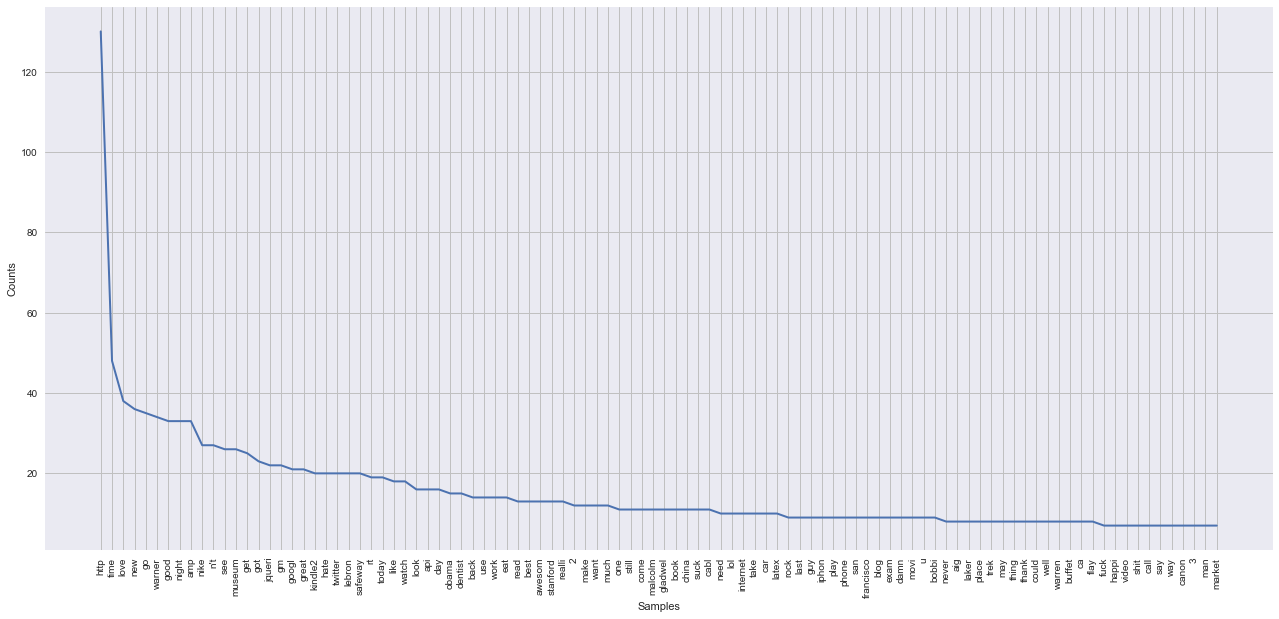

In [46]:
plt.figure(figsize=(22, 10));
fd.plot(100, cumulative=False)

In [47]:
fd.hapaxes()[:3] # - тут все слова, что встретились лишь единожды

['stellargirl', 'loooooooovvvvvvee', 'fantast']

In [48]:
len(fd.keys()), len(fd.hapaxes())

(1810, 1211)

In [49]:
df['frequent_cleansed'] = df.cleansed_text.str.split()\
    .apply(lambda ss: ' '.join([x for x in ss if x not in fd.hapaxes()]))

In [50]:
df.head()

,polarity,text,cleansed_text,frequent_cleansed
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...,stellargirl loooooooovvvvvvee kindle2 dx cool ...,kindle2 dx cool 2 right
1,4,Reading my kindle2... Love it... Lee childs i...,read kindle2 love lee child good read,read kindle2 love child good read
2,4,"Ok, first assesment of the #kindle2 ...it fuck...",ok first asses kindle2 fuck rock,ok first kindle2 fuck rock
3,4,@kenburbary You'll love your Kindle2. I've had...,kenburbari love kindle2 mine month never look ...,love kindle2 month never look back new big one...
4,4,@mikefish Fair enough. But i have the Kindle2...,mikefish fair enough kindle2 think perfect,enough kindle2 think perfect


Кстати, по той же логике, но обратной, мы удаляли стоп-слова, считая, что все слова, которые везде всплывают слишком _часто_, тоже бесполезны.

# Кодирование текста

## Bag of Words

In [78]:
from sklearn.feature_extraction.text import CountVectorizer

In [79]:
cv = CountVectorizer()

X_bow = cv.fit_transform(df.frequent_cleansed).todense();
y = df.polarity

In [81]:
clf = LogisticRegression()
clf.fit(X_bow, y);

In [93]:
df.polarity[-4:]

494    0
495    4
496    0
497    0
Name: polarity, dtype: int64

In [84]:
df.frequent_cleansed[-4:]

494    hate word hate page hate latex said hate latex...
495                                 back text lt 3 latex
496                               iran see iran iran far
497                 read tweet come iran whole thing sad
Name: frequent_cleansed, dtype: object

In [103]:
df.frequent_cleansed[3:4]

3    love kindle2 month never look back new big one...
Name: frequent_cleansed, dtype: object

In [104]:
text = cv.transform(df.frequent_cleansed[3:4])

In [105]:
eli5.explain_prediction_sklearn(clf, text, feature_names=list(cv.vocabulary_.keys()))

Explanation(estimator="LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,\n          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n          verbose=0, warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='instead', weight=0.67180714974033151, std=None, value=1.0), FeatureWeight(feature='http', weight=0.58595435538928708, std=None, value=1.0), FeatureWeight(feature='kid', weight=0.054430154907830132, std=None, value=1.0)], neg=[FeatureWeight(feature='season', weight=-1.0115208916559508, std=None, value=1.0), FeatureWeight(feature='io2009', weight=-0.80626273624224243, std=None, value=1.0), FeatureWeight(feature='expect', weight=-0.71738996011804057, std=None, value=1.0), FeatureWeight(feature='g2', weight=-0.70328217629626499, std=None, value=1.0), FeatureWeight(feature='servic', weight=-0.65998231008232644, std=None, value=1.0), FeatureWeight(feature='<BIAS>', weight=-0.4991715224110555, std=None, value=1.0), FeatureWeight(feature='anymor', weight=-0.18077969512168424, std=None, value=1.0), FeatureWeight(feature='stop', weight=-0.15752912825462981, std=None, value=1.0), FeatureWeight(feature='boy', weight=-0.14131424855031213, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.027037386761633864, score=-3.5650410086950579, weighted_spans=None), TargetExplanation(target=2, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='servic', weight=0.20194167675292399, std=None, value=1.0), FeatureWeight(feature='kid', weight=0.16181946575514988, std=None, value=1.0), FeatureWeight(feature='g2', weight=0.12796567504117912, std=None, value=1.0), FeatureWeight(feature='expect', weight=0.057418138545891798, std=None, value=1.0)], neg=[FeatureWeight(feature='io2009', weight=-1.6006129488343921, std=None, value=1.0), FeatureWeight(feature='<BIAS>', weight=-1.1654641926582481, std=None, value=1.0), FeatureWeight(feature='http', weight=-0.92391517454890582, std=None, value=1.0), FeatureWeight(feature='instead', weight=-0.73287735326535586, std=None, value=1.0), FeatureWeight(feature='stop', weight=-0.40497839069309277, std=None, value=1.0), FeatureWeight(feature='season', weight=-0.11702003692002209, std=None, value=1.0), FeatureWeight(feature='anymor', weight=-0.075914533178062044, std=None, value=1.0), FeatureWeight(feature='boy', weight=-0.061912676614150716, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.010442969490973789, score=-4.5335503506170847, weighted_spans=None), TargetExplanation(target=4, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='io2009', weight=1.7867572806738949, std=None, value=1.0), FeatureWeight(feature='season', weight=0.93317731625179134, std=None, value=1.0), FeatureWeight(feature='stop', weight=0.51363351813692104, std=None, value=1.0), FeatureWeight(feature='expect', weight=0.42631862270738369, std=None, value=1.0), FeatureWeight(feature='g2', weight=0.41236026383917357, std=None, value=1.0), FeatureWeight(feature='servic', weight=0.3444672913107148, std=None, value=1.0), FeatureWeight(feature='http', weight=0.24394182769757952, std=None, value=1.0), FeatureWeight(feature='anymor', weight=0.19154225794138829, std=None, value=1.0), FeatureWeight(feature='boy', weight=0.16169766430263929, std=None, value=1.0)], neg=[FeatureWeight(feature='<BIAS>', weight=-0.83101231374149731, std=None, value=1.0), FeatureWeight(feature='kid', weight=-0.25992593393808877, std=None, value=1.0), FeatureWeight(feature='instead', weight=-0.051303078360734305, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.9625196437473923, score=3.8716547168211672, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [58]:
# X_bow

## TF-IDF

Введем новую метрику: __TF-IDF__, что расшифровывается как _"Term Frequency-Inverse Document Frequency"_. Именно из таких двух частей, двух множителей она и состоит. Обозначим некоторый встретившийся в документе $d$ (в нашем случае в твите) нам токен за $t$, тогда TF-IDF будет вычисляться как:

$$ TFIDF_{t,d} = TF_{t,d} \cdot IDF_{t,d}$$

* $TF_{t,d}$ - частота встречаемости терма $t$ в документе $d$. Для базовой имплементации достаточно просто посчитать количество, хотя иногда это количество логарифмируют.


* $IDF_{t,d} = \log{\frac{D}{n_d}}$ - обратная частота в документах измеряет важность терма $t$ во всей коллекции. В приведенной здесь формуле $D$ - общее количество документов, $n_d$ - количество документов, содержащих $t$.

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [61]:
tfidf = TfidfVectorizer(min_df=1)

In [62]:
X_tfidf = tfidf.fit_transform(df.frequent_cleansed).todense()

In [65]:
idf = tfidf.idf_
terms_score  = list(zip(tfidf.get_feature_names(), idf))
sorted(terms_score, key=lambda x: -x[1])[:20]

[('arab', 6.5194589151915734),
 ('blah', 6.5194589151915734),
 ('cox', 6.5194589151915734),
 ('d90', 6.5194589151915734),
 ('dum', 6.5194589151915734),
 ('eo', 6.5194589151915734),
 ('feed', 6.5194589151915734),
 ('fish', 6.5194589151915734),
 ('fit', 6.5194589151915734),
 ('hummer', 6.5194589151915734),
 ('india', 6.5194589151915734),
 ('indian', 6.5194589151915734),
 ('number', 6.5194589151915734),
 ('receip', 6.5194589151915734),
 ('sale', 6.5194589151915734),
 ('tenni', 6.5194589151915734),
 ('upsid', 6.5194589151915734),
 ('view', 6.5194589151915734),
 ('wrong', 6.5194589151915734),
 ('2010', 6.1139938070834088)]

## Word2Vec

https://habrahabr.ru/company/ods/blog/329410/

https://www.kaggle.com/cpmpml/spell-checker-using-word2vec

## Счетчики

Можно добавить признак, равный:

$$ (n_{dw})_{w \in W} $$

, то есть количество вхождений слова $w$ в документ $d$.

## Хэширование

То есть применение преобразования вида $ w \rightarrow h(w) $, где $h(w)$ - хэш-функция с $2^b$ значениями. Получаем "кластеризацию" слов, если $2^b < |W|$.

## Тематическое моделирование

[Работа Воронцова К.В.](http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf)

[Github](https://habrahabr.ru/post/312596/)

* [BigARTM](https://github.com/bigartm/bigartm)

## N-граммы

* Простейший случай - __биграммы__: мы просто работаем с парами слов, считая, что они неразделимы.
* Это же обощается на N идущих слов подряд: __N-граммы (N-grams)__
* Наконец, если мы разрешаем быть словам в N-граммах разнесенными не больше чем на $k$, то это будет называть __k-skip-N-grams__.

## kNN

В ближайших соседей можно, как мы знаем, загрузить свою метрику. Для текстов ею вполне может послужить __LSH__ (Locality Sensitive Hashing), реализованный, например, в пакете [datasketch](https://github.com/ekzhu/datasketch).

# Модели

Вкратце - мораль: как ты тексты не кодируй, выходят очень разреженные матрицы. Поэтому особенно хорошо заходят линейные модели типа той же логистической регрессии, которые умеют работать с разреженными признаками.

In [66]:
from sklearn.model_selection import cross_val_score

In [74]:
from sklearn.linear_model import LogisticRegression

In [75]:
clf = LogisticRegression()

In [76]:
scores = cross_val_score(clf, X_bow, y)
print(np.mean(scores), '+/-', 2 * np.std(scores))

0.674703240471 +/- 0.0256281836121


In [77]:
import eli5

In [ ]:
eli5.explain_prediction_sklearn(clf, )

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [71]:
scores = cross_val_score(RandomForestClassifier(n_estimators=100), X_bow, y)
print(np.mean(scores), '+/-', 2 * np.std(scores))

0.630453368546 +/- 0.086873101698
